# Введение

### Тема работы

Исследование особенностей и трендов в музыке с использованием данных Spotify.

### Цели работы

1. Исследовать основные характеристики музыкальных композиций из датасета Spotify

2. Выявить закономерности и тренды в музыкальных данных

3. Разработать систему рекомендаций на основе полученных данных

В работе использован датасет, содержащий информацию о 30 000 песнях из платформы Spotify. Датасет доступен на платформе Kaggle по ссылке: [Kaggle.](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs)

Словаь данных можно рассмотреть в Анализ данных/Загрузка и обзор данных/Словарь данных

# Иморт библиотек

In [2]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

# Анализ данных

## Загрузка и обзор данных

### Загрузка данных

In [3]:
loaded_df = pd.read_csv('data/spotify_songs.csv')

In [4]:
loaded_df.head()

track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Justin Bieber) [Loud Luxury...               2019-06-14   
1                    Memories (Dillon Francis Remix)               2019-12-13   
2                    All the Time (Don Diablo Remix)               2019-07-05   
3                        Call You Mine - The Remixes               2019-07-19   
4            Someone You Loved (Future Humans Remix)               2019-03-05   

  playlist_name             playlist_id playlist_genre  ... key  loudness  \
0     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...   6    -2.634   
1     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...  11    -4.969   
2     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...   1    -3.432   
3     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...   7    -3.778   
4     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...   1    -4.672   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     1       0.0583        0.1020          0.000000    0.0653    0.518   
1     1       0.0373        0.0724          0.004210    0.3570    0.693   
2     0       0.0742        0.0794          0.000023    0.1100    0.613   
3     1       0.1020        0.0287          0.000009    0.2040    0.277   
4     1       0.0359        0.0803          0.000000    0.0833    0.725   

     tempo  duration_ms  
0  122.036       194754  
1   99.972       162600  
2  124.008       176616  
3  121.956       169093  
4  123.976       189052  

[5 rows x 23 columns]

### Словарь данных

| переменная               | тип       | описание |
|:---|:---|:-----------|
| track_id                 | символьный | Уникальный ID песни |
| track_name               | символьный | Название песни |
| track_artist             | символьный | Исполнитель песни |
| track_popularity         | числовой   | Популярность песни (0-100), где выше - лучше |
| track_album_id           | символьный | Уникальный ID альбома |
| track_album_name         | символьный | Название альбома песни |
| track_album_release_date | символьный | Дата выпуска альбома |
| playlist_name            | символьный | Название плейлиста |
| playlist_id              | символьный | ID плейлиста |
| playlist_genre           | символьный | Жанр плейлиста |
| playlist_subgenre        | символьный | Поджанр плейлиста |
| danceability             | числовой   | Танцевальность описывает, насколько трек подходит для танцев, основываясь на комбинации музыкальных элементов, включая темп, стабильность ритма, силу бита и общую регулярность. Значение 0.0 наименее танцевальное, а 1.0 - наиболее танцевальное. |
| energy                   | числовой   | Энергия - это мера от 0.0 до 1.0, представляющая воспринимаемую меру интенсивности и активности. Как правило, энергичные треки воспринимаются как быстрые, громкие и шумные. Например, дэт-метал имеет высокую энергию, в то время как прелюдия Баха получает низкую оценку по этой шкале. Воспринимаемые характеристики, влияющие на этот атрибут, включают динамический диапазон, воспринимаемую громкость, тембр, частоту начала и общую энтропию. |
| key                      | числовой   | Предполагаемая общая тональность трека. Целые числа соответствуют высотам звука, используя стандартную нотацию Pitch Class. Например, 0 = C, 1 = C♯/D♭, 2 = D и так далее. Если тональность не определена, значение равно -1. |
| loudness                 | числовой   | Общая громкость трека в децибелах (дБ). Значения громкости усредняются по всему треку и полезны для сравнения относительной громкости треков. Громкость - это качество звука, которое является основным психологическим коррелятом физической силы (амплитуды). Значения обычно варьируются от -60 до 0 дБ. |
| mode                     | числовой   | Режим указывает на модальность (мажор или минор) трека, тип гаммы, из которой происходит его мелодическое содержание. Мажор представлен 1, а минор - 0. |
| speechiness              | числовой   | Параметр определяет наличие разговорных слов в треке. Чем более исключительно речеподобна запись (например, ток-шоу, аудиокнига, поэзия), тем ближе к 1.0 значение атрибута. Значения выше 0.66 описывают треки, которые, вероятно, состоят полностью из разговорных слов. Значения между 0.33 и 0.66 описывают треки, которые могут содержать как музыку, так и речь, либо в отдельных секциях, либо наложенными, включая такие случаи, как рэп-музыка. Значения ниже 0.33 скорее всего представляют музыку и другие не речевые треки. |
| acousticness             | числовой   | Мера уверенности от 0.0 до 1.0 в том, является ли трек акустическим. 1.0 представляет высокую уверенность в том, что трек акустический. |
| instrumentalness         | числовой   | Предсказывает, содержит ли трек вокал. Звуки "У" и "А" в этом контексте рассматриваются как инструментальные. Рэп или треки с разговорной речью явно "вокальные". Чем ближе значение инструментальности к 1.0, тем выше вероятность того, что трек не содержит вокального контента. Значения выше 0.5 предназначены для представления инструментальных треков, но уверенность выше по мере приближения значения к 1.0. |
| liveness                 | числовой   | Определяет присутствие аудитории в записи. Более высокие значения живости представляют повышенную вероятность того, что трек был исполнен вживую. Значение выше 0.8 дает сильную вероятность того, что трек живой. |
| valence                  | числовой   | Мера от 0.0 до 1.0, описывающая музыкальную позитивность, передаваемую треком. Треки с высокой валентностью звучат более позитивно (например, счастливо, весело, эйфорично), в то время как треки с низкой валентностью звучат более негативно (например, грустно, подавленно, сердито). |
| tempo                    | числовой   | Общий предполагаемый темп трека в ударах в минуту (BPM). В музыкальной терминологии темп - это скорость или ритм данного произведения и напрямую происходит от средней продолжительности удара. |
| duration_ms              | числовой   | Продолжительность песни в миллисекундах |

### Информация о данных

In [5]:
loaded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

### Статистическая сводка для числовыхчисловых признаков

In [6]:
def num_obj_cols(df):
    return df.select_dtypes(['float64', 'int64']).columns.tolist(), df.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
df_num_cols, df_obj_cols = num_obj_cols(loaded_df)

loaded_df[df_num_cols].describe()

track_popularity  danceability        energy           key  \
count      32833.000000  32833.000000  32833.000000  32833.000000   
mean          42.477081      0.654850      0.698619      5.374471   
std           24.984074      0.145085      0.180910      3.611657   
min            0.000000      0.000000      0.000175      0.000000   
25%           24.000000      0.563000      0.581000      2.000000   
50%           45.000000      0.672000      0.721000      6.000000   
75%           62.000000      0.761000      0.840000      9.000000   
max          100.000000      0.983000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  32833.000000  32833.000000  32833.000000  32833.000000   
mean      -6.719499      0.565711      0.107068      0.175334   
std        2.988436      0.495671      0.101314      0.219633   
min      -46.448000      0.000000      0.000000      0.000000   
25%       -8.171000      0.000000      0.041000      0.015100   
50%       -6.166000      1.000000      0.062500      0.080400   
75%       -4.645000      1.000000      0.132000      0.255000   
max        1.275000      1.000000      0.918000      0.994000   

       instrumentalness      liveness       valence         tempo  \
count      32833.000000  32833.000000  32833.000000  32833.000000   
mean           0.084747      0.190176      0.510561    120.881132   
std            0.224230      0.154317      0.233146     26.903624   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.092700      0.331000     99.960000   
50%            0.000016      0.127000      0.512000    121.984000   
75%            0.004830      0.248000      0.693000    133.918000   
max            0.994000      0.996000      0.991000    239.440000   

         duration_ms  
count   32833.000000  
mean   225799.811622  
std     59834.006182  
min      4000.000000  
25%    187819.000000  
50%    216000.000000  
75%    253585.000000  
max    517810.000000

Числовые признаки плохо нормированы и имеют разные распределения

### Исследование на пропуски

In [7]:
loaded_df.isnull().sum()

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

В track_name, track_artist, track_album_name есть по 5 пропусков, скорее всего это 5 записей, где в каждой пропущено 3 значения.

### Исследование на дублирование данных

In [8]:
loaded_df.duplicated().sum()

0

## Подготовка данных

Избавимся от пропусков в данных самым  простым способом, просто удалим их, так как пропусков совсем немного по сравнению с общим количеством данных, а так же пропущенные данные крайне не осмысленны и не идентифицируемы, ввиду пропусков вторичных ключей (названия песен, имена авторов и тд)

In [9]:
df = loaded_df.dropna()
df.isna().any().sum()

0

Исправим неправильно заполненные значения даты, а так же создадим новые фичи: год и месяц

In [10]:
def convert_dates(date):
    if len(date) == 4:
        return date + '-01-01'
    if len(date) == 7:
        return date + '-01'
    return date

df['track_album_release_date'] = df['track_album_release_date'].apply(convert_dates)
df['year'] = pd.DatetimeIndex(df['track_album_release_date']).year.astype(int)
df['month'] = pd.DatetimeIndex(df['track_album_release_date']).month.astype(int)

In [11]:
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'])

In [12]:
df.head(3)

track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   

   track_artist  track_popularity          track_album_id  \
0    Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1      Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2  Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Justin Bieber) [Loud Luxury...               2019-06-14   
1                    Memories (Dillon Francis Remix)               2019-12-13   
2                    All the Time (Don Diablo Remix)               2019-07-05   

  playlist_name             playlist_id playlist_genre  ... mode  speechiness  \
0     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...    1       0.0583   
1     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...    1       0.0373   
2     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...    0       0.0742   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0        0.1020          0.000000    0.0653    0.518  122.036       194754   
1        0.0724          0.004210    0.3570    0.693   99.972       162600   
2        0.0794          0.000023    0.1100    0.613  124.008       176616   

   year  month  
0  2019      6  
1  2019     12  
2  2019      7  

[3 rows x 25 columns]

Получим списки числовых и текстовых фичей

In [13]:
df_num_cols, df_obj_cols = num_obj_cols(df)
df_num_cols, df_obj_cols

(['track_popularity',
  'danceability',
  'energy',
  'key',
  'loudness',
  'mode',
  'speechiness',
  'acousticness',
  'instrumentalness',
  'liveness',
  'valence',
  'tempo',
  'duration_ms',
  'year',
  'month'],
 ['track_id',
  'track_name',
  'track_artist',
  'track_album_id',
  'track_album_name',
  'track_album_release_date',
  'playlist_name',
  'playlist_id',
  'playlist_genre',
  'playlist_subgenre'])

## Визуализация и исследование признаков

Построим набор гистограмм, отображающих распределение ключевых характеристик музыкальных треков: ритмичность, энергичность, настроение, темп и тд. 

## Ключевые тенденции в музыке

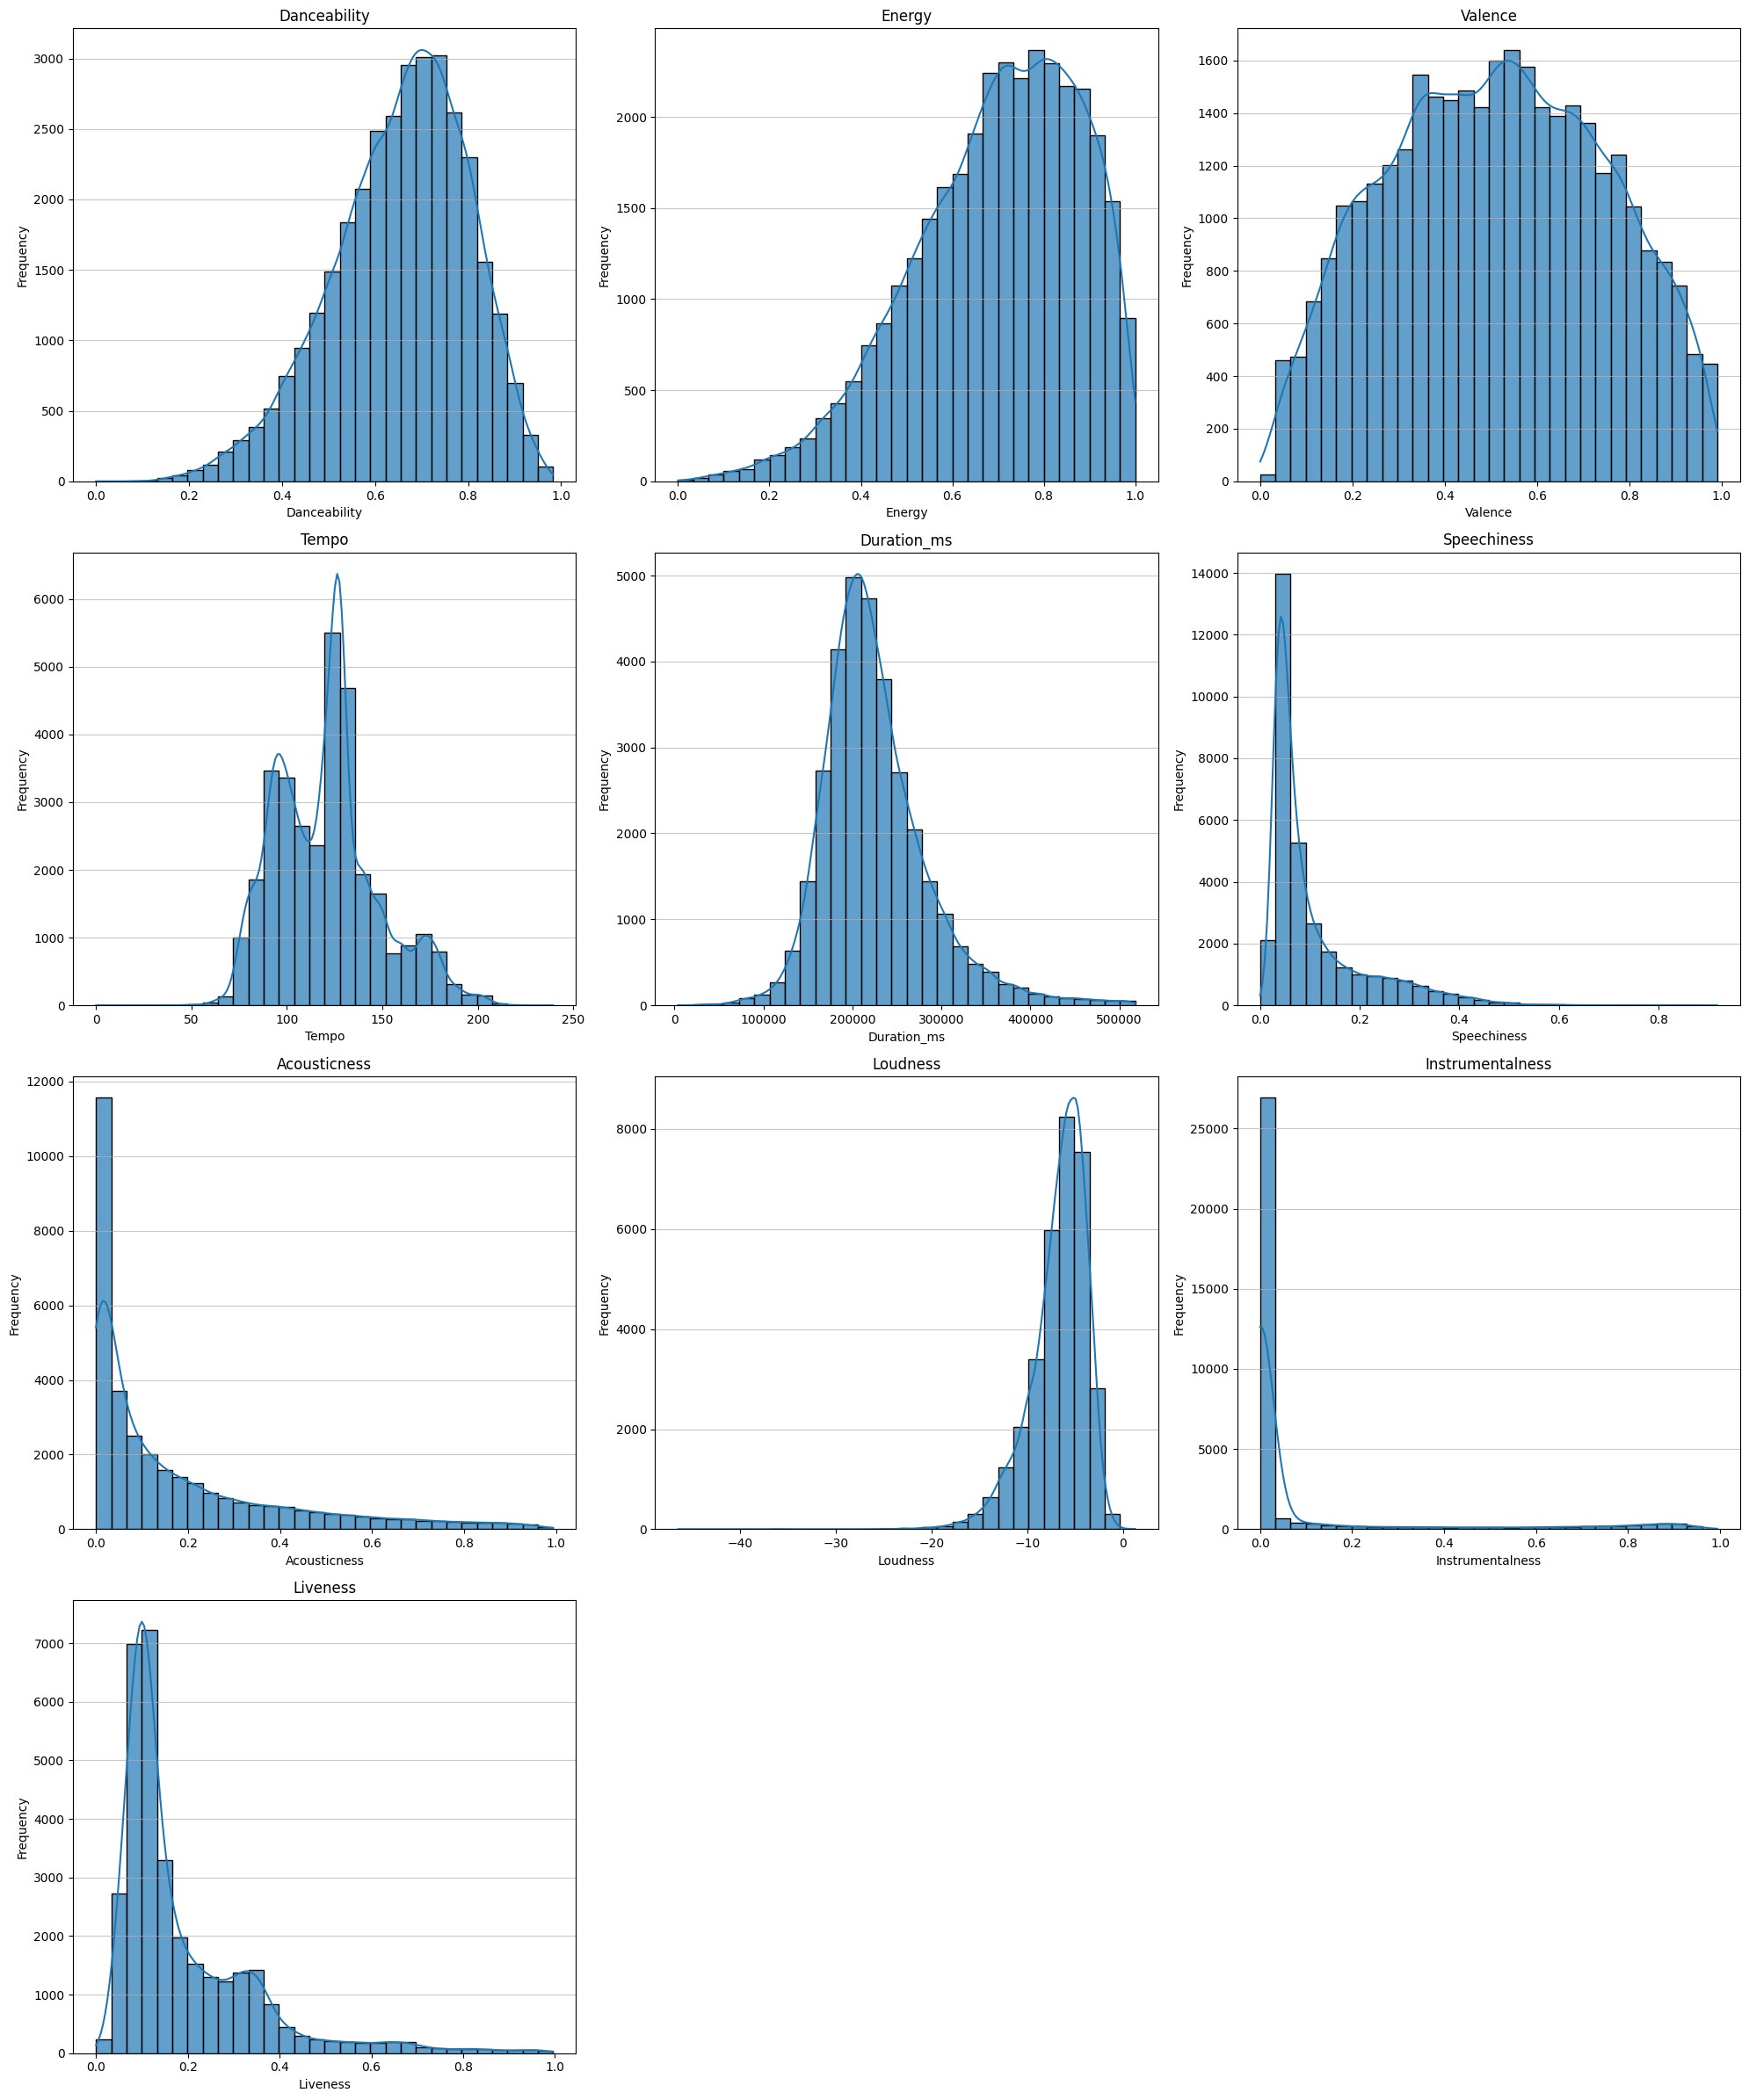

In [14]:
music_features = ['danceability', 'energy', 'valence', 'tempo', 
            'duration_ms', 'speechiness', 
            'acousticness', 'loudness', 'instrumentalness', 'liveness']
n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 24))

sns.set_palette('crest')

for i, feature in enumerate(music_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    sns.histplot(df[feature], kde=True, bins=30, edgecolor='black', alpha=0.7, ax=ax)
    ax.set_title(f'{feature.capitalize()}')
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', alpha=0.7)

axes[-1, -1].remove()
axes[-1, -2].remove()

plt.tight_layout()
plt.show()

"Instrumentalness" показывает, содержит ли трек вокал, и можно заметить, что подавляющее большинство произведений в датасете его содержит (0), получается, что в данном контексте признак крайне слабо информативен.

Теперь построим ящики с усами для дополнительного анализа на выбросы

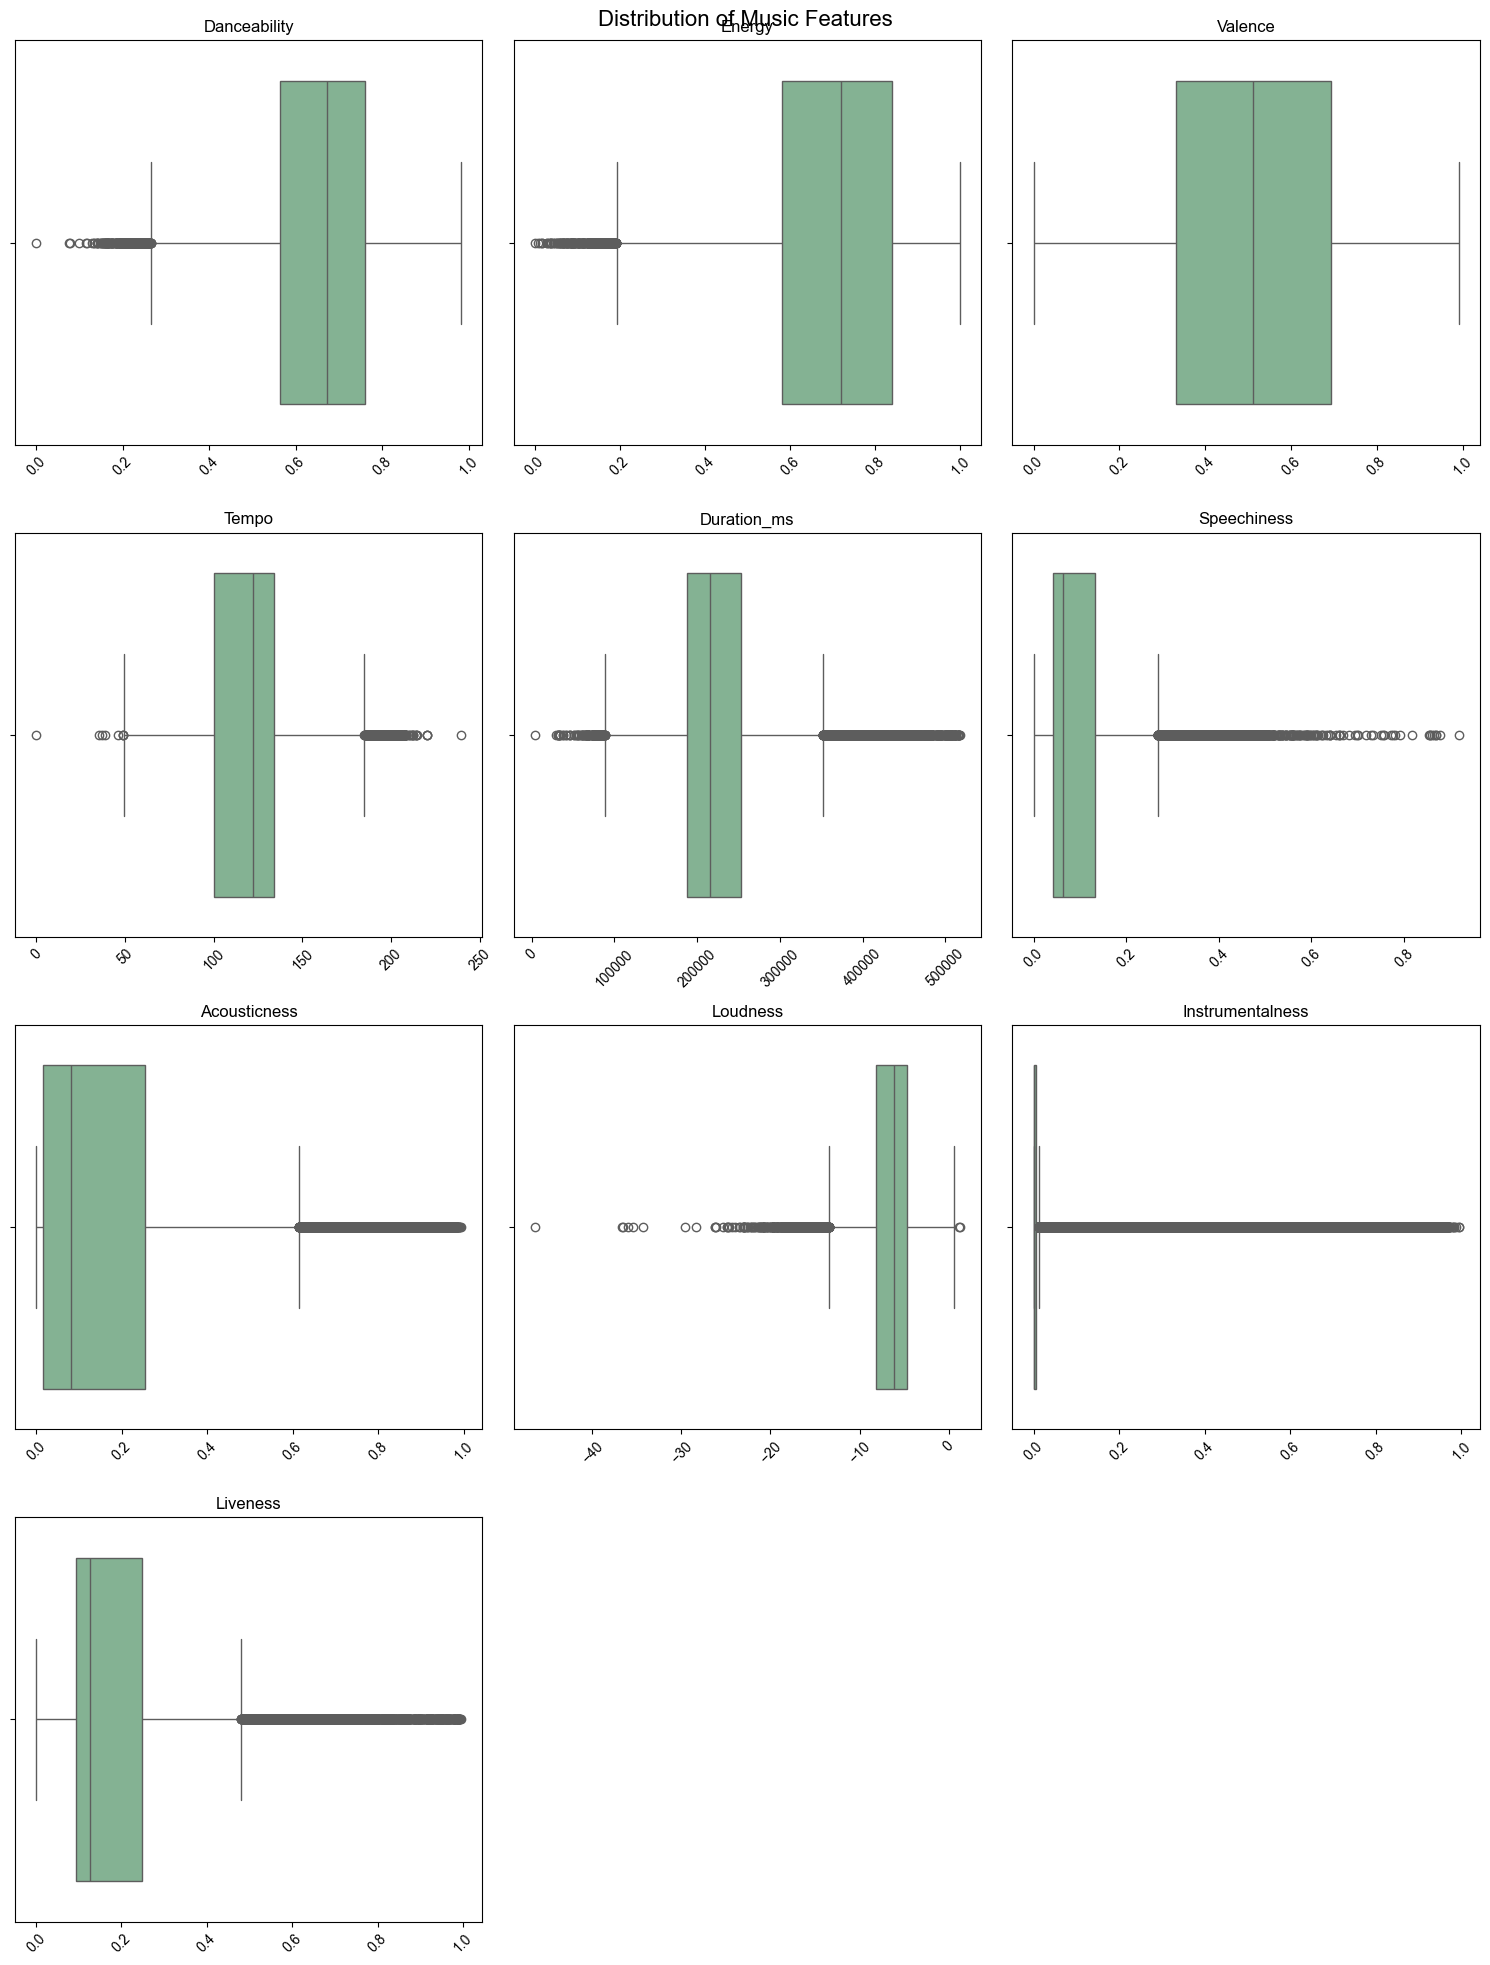

In [15]:
n_features = len(music_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
fig.suptitle('Distribution of Music Features', fontsize=16)

sns.set_style("whitegrid")
sns.set_palette('crest')

for i, feature in enumerate(music_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    sns.boxplot(x=df[feature], ax=ax)
    ax.set_title(f'{feature.capitalize()}', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

for i in range(n_features, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

plt.tight_layout()
plt.show()

Как и было сказано, instumentalness крайне плохая для работы с данными фича.
Так же довольно много единичных значений в Speechiness, Liveness и Loudness что говорит о сильном преобладании каких то особых значений в данных признаках.

Отдельно рассмотрим частоту треков различной популярности, так как популярность трека - это ключевая фича, которая напрямую показывает насколько трек нравится среднему пользователю

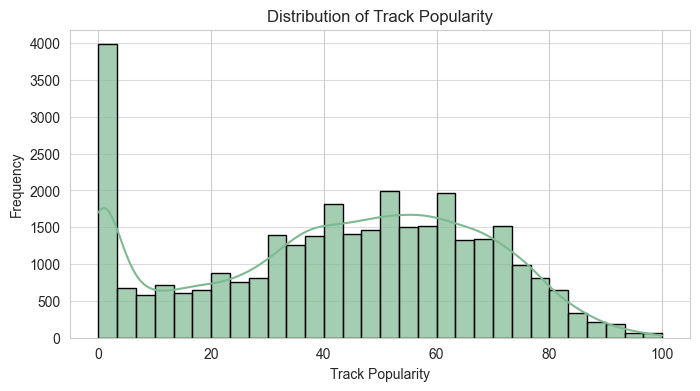

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(df['track_popularity'], kde=True, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Track Popularity')
plt.xlabel('Track Popularity')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.7)
plt.show()

Распределение популярности довольно ровное, что дает нам на хорошую, в теории, рекомендательную систему с большой кокурентоспособностью треков.

Сделаем график средней популярности по жанрам

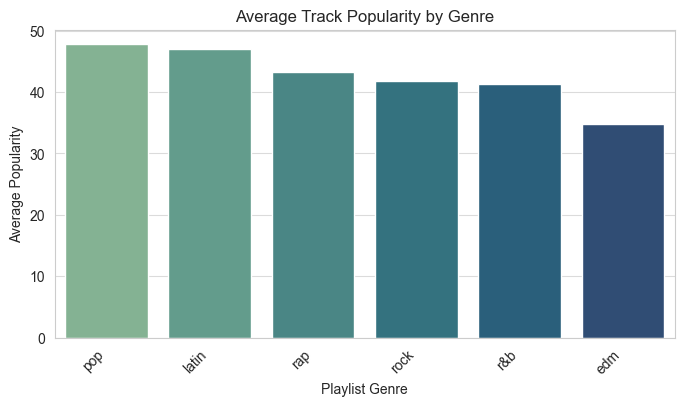

In [17]:
plt.figure(figsize=(8, 4))
genre_popularity = df.groupby('playlist_genre')['track_popularity'].mean().sort_values(ascending=False)
sns.barplot(x=genre_popularity.index, y=genre_popularity.values, palette='crest')
plt.title('Average Track Popularity by Genre')
plt.xlabel('Playlist Genre')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.7)
plt.show()

Наиболее популярный жанр музыки pop, что не удивительно, так как pop - popular music

Построим график популярности по поджанрам музыки

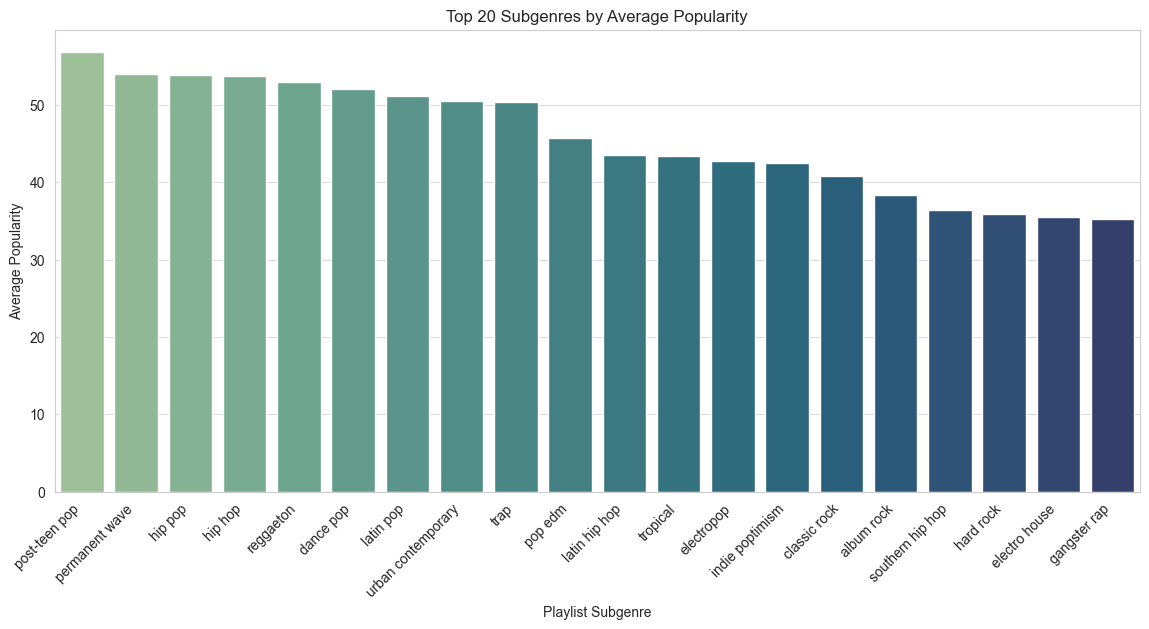

In [18]:
plt.figure(figsize=(14, 6))
subgenre_popularity = df.groupby('playlist_subgenre')['track_popularity'].mean().sort_values(ascending=False).head(20)
sns.barplot(x=subgenre_popularity.index, y=subgenre_popularity.values, palette='crest')
plt.title('Top 20 Subgenres by Average Popularity')
plt.xlabel('Playlist Subgenre')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.7)
plt.show()

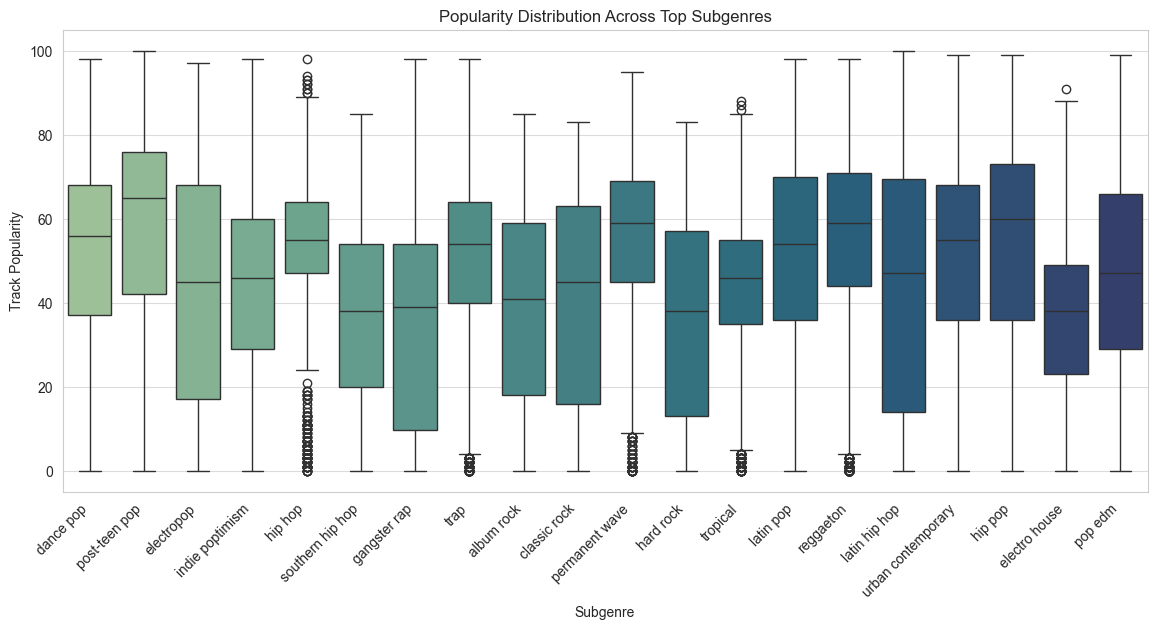

In [19]:
top_subgenres_data = df[df['playlist_subgenre'].isin(subgenre_popularity.index)]
plt.figure(figsize=(14, 6))
sns.boxplot(data=top_subgenres_data, x='playlist_subgenre', y='track_popularity', palette='crest')
plt.title('Popularity Distribution Across Top Subgenres')
plt.xlabel('Subgenre')
plt.ylabel('Track Popularity')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.7)
plt.show()

Можно заметить, что график почти полностью повторяет график обычных жанров, следовательно может быть излишне использвать данный признак при создании простых рекомендаций. График ящиков с усами же показывает довольно плотное распределение без сильных выбросов, а значит каждый поджанр имеет свою ярко выраженную популярность

Создадим тепловую матрицу, чтобы определить корреляцию признаков

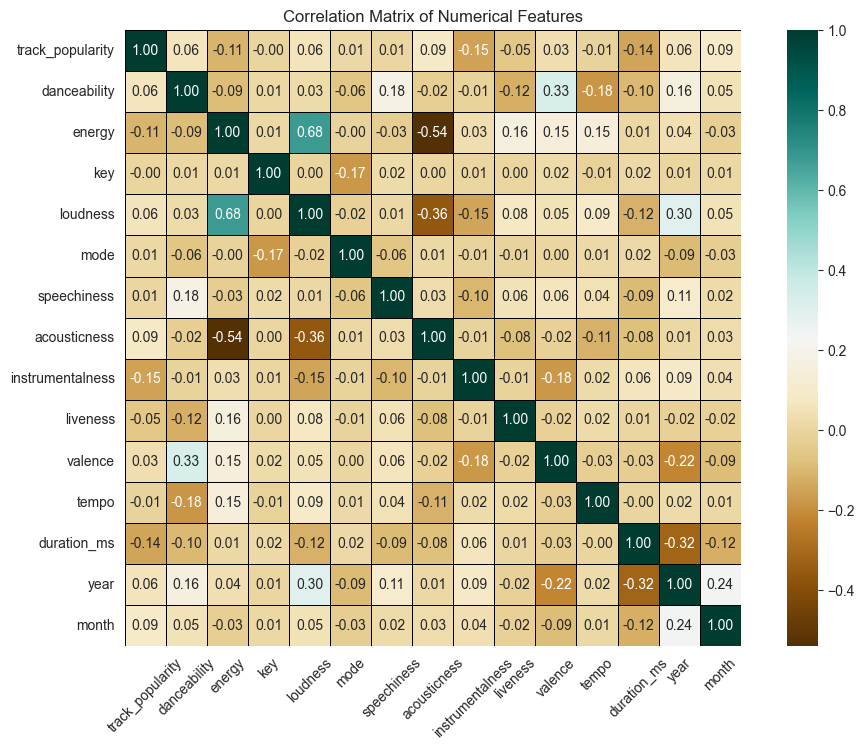

In [20]:
corr_matrix = df[df_num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='BrBG', cbar=True, square=True, linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45)
plt.show()

Предсказуемо, энергия и громкость, а так же энергия и акустичность имеют сильную корреляцию

Сделаем график изменения музыкальных фич по годам

In [21]:
from sklearn.preprocessing import MinMaxScaler

music_features = ['danceability', 'energy', 'valence', 
                  'duration_ms', 'speechiness', 
                  'acousticness', 'instrumentalness', 
                  'liveness', 'track_popularity']

avg_features_by_year = df.groupby('year')[music_features].mean()

scaler = MinMaxScaler()
normalized_avg_features = pd.DataFrame(scaler.fit_transform(avg_features_by_year), 
                                       columns=music_features, 
                                       index=avg_features_by_year.index)

normalized_avg_features.reset_index(inplace=True)
melted_data = normalized_avg_features.melt(id_vars='year', var_name='feature', value_name='normalized_value')

pio.templates.default = "seaborn"
fig = px.line(melted_data, x='year', y='normalized_value', color='feature',
              markers=True, title='Trends of Normalized Musical Features Over Years')

fig.update_layout(xaxis_title='Year',
                  yaxis_title='Normalized Average Value',
                  legend_title='Features')

fig.show()

Вывод из графика:
- До 1970 года данные крайне хаотичны, скорее всего, не соотвествуют дейстивтельности и не могут быть взяты для анализа
- Энергичность всегда была одним из важнейших аспектов музыки
- Наличие слов в песне и ее танцевальность до 1990 года не были популярны, однако в наше время это не так
- В последнее время выпускаются довольно короткие треки, по сравнению с прошлым


Рассмотрим некоторые музыкальные признаки в контексте жанров 

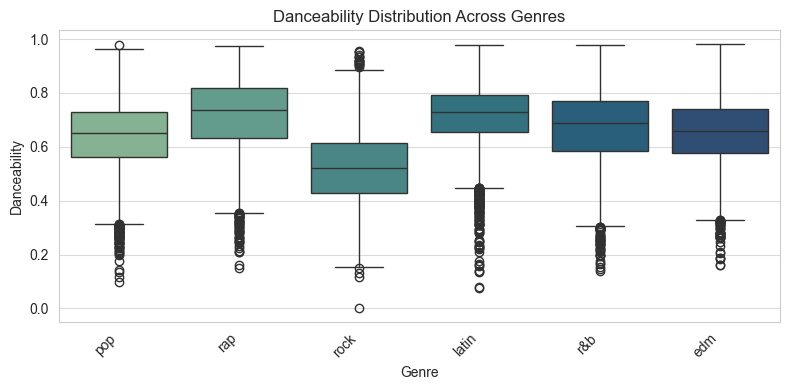

In [22]:
top_genres = df['playlist_genre'].value_counts().index
filtered_genres = df[df['playlist_genre'].isin(top_genres)]

plt.figure(figsize=(8, 4))
sns.boxplot(data=filtered_genres, x='playlist_genre', y='danceability', palette='crest')
plt.title('Danceability Distribution Across Genres')
plt.xlabel('Genre')
plt.ylabel('Danceability')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

Танцевальность больше всего достигается в рэпе и латинской музыке

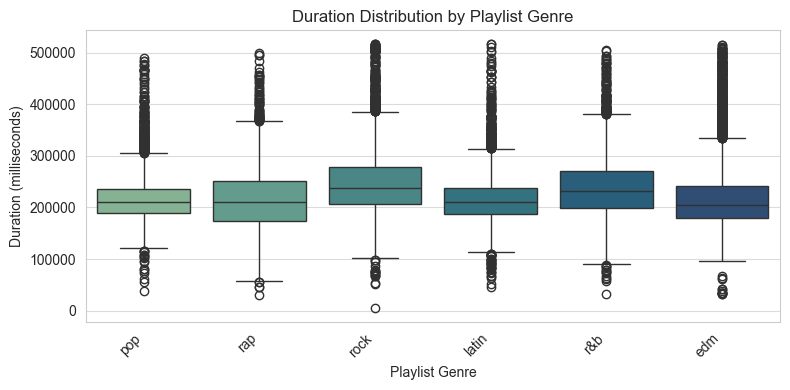

In [23]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='playlist_genre', y='duration_ms', palette='crest')
plt.title('Duration Distribution by Playlist Genre')
plt.xlabel('Playlist Genre')
plt.ylabel('Duration (milliseconds)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

Наибольшую продолжительность имеет рок

Построим графики зависимостей между различными фичами и популярностью

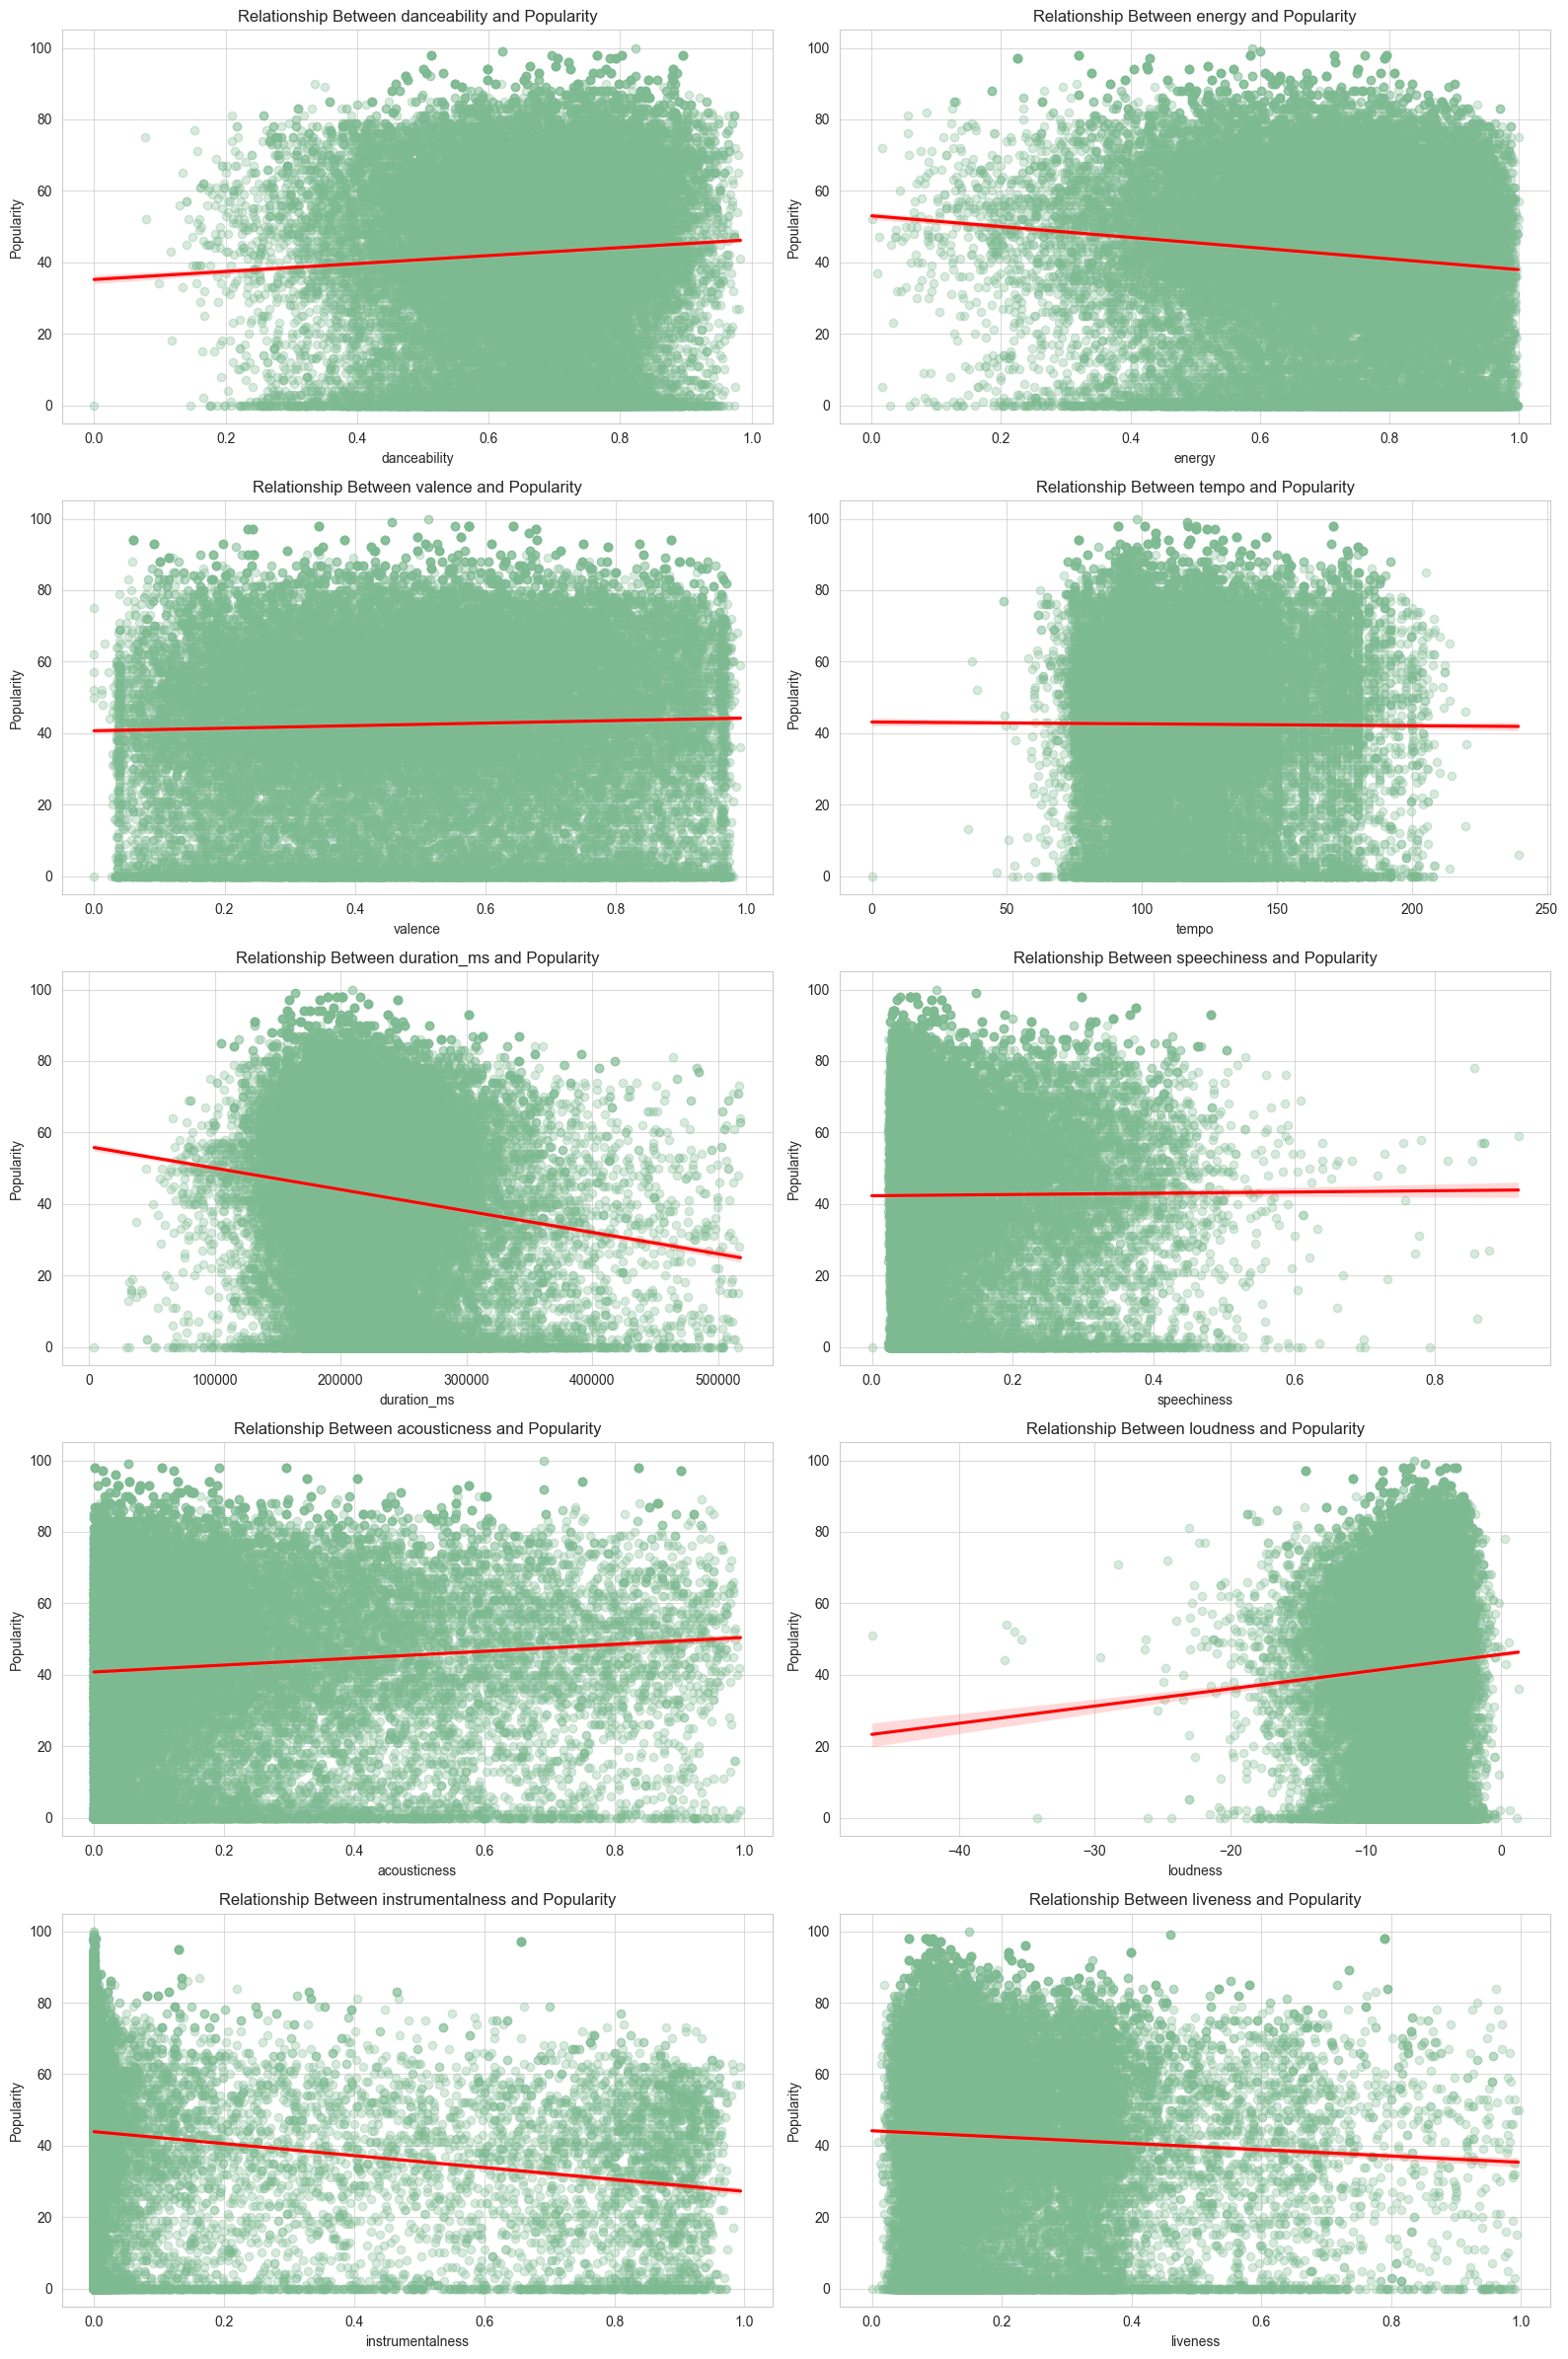

In [24]:
music_features = ['danceability', 'energy', 'valence', 'tempo', 
                  'duration_ms', 'speechiness', 
                  'acousticness', 'loudness', 'instrumentalness', 'liveness']

plt.figure(figsize=(16, 24))
for i, feature in enumerate(music_features, 1):
    plt.subplot(5, 2, i)
    sns.regplot(data=df, x=feature, y='track_popularity', 
                scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
    plt.title(f'Relationship Between {feature} and Popularity')
    plt.xlabel(feature)
    plt.ylabel('Popularity')
    plt.grid(axis='both', alpha=0.7)
plt.tight_layout()
plt.show()


Построим график распределения жанров на стыке различных музыкальных фич

<Figure size 1600x2400 with 0 Axes>

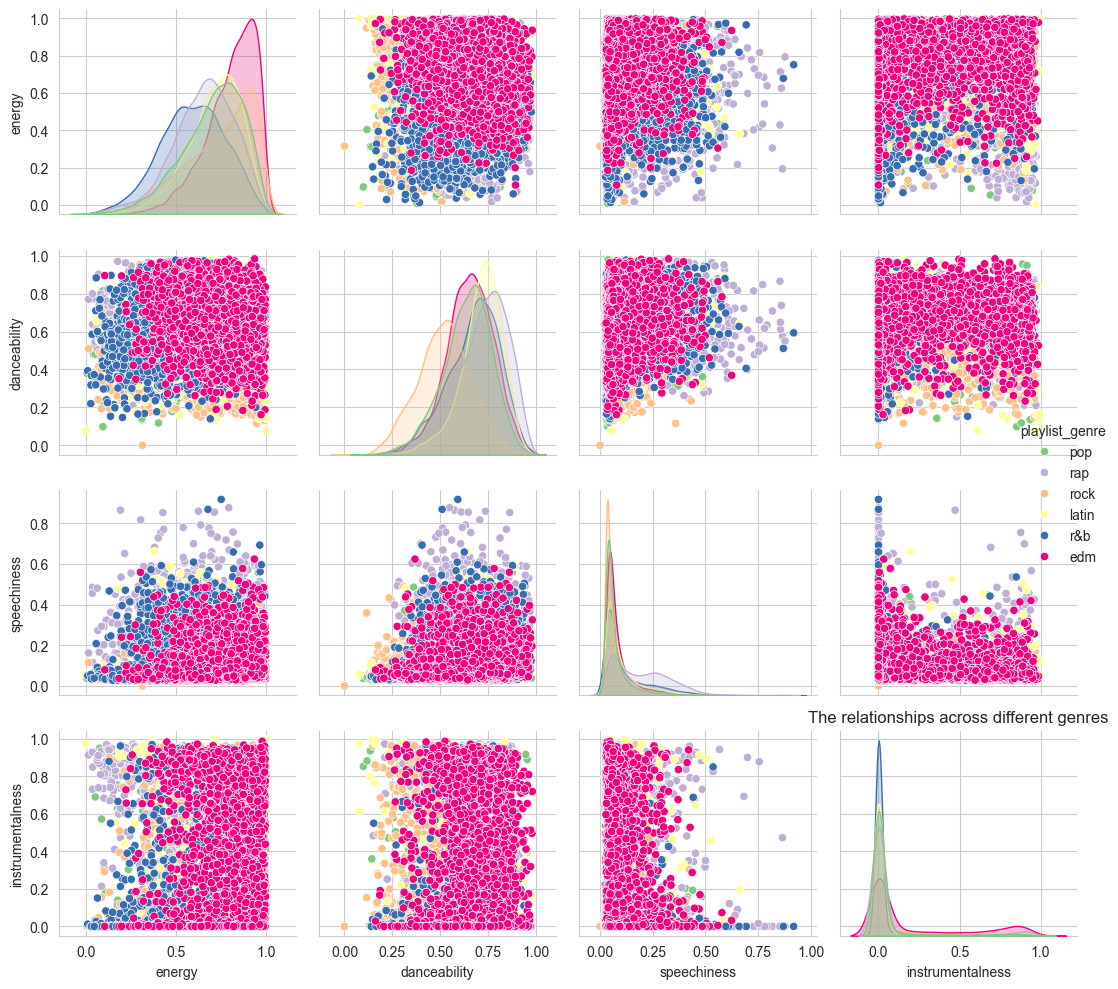

In [25]:
plt.figure(figsize=(16, 24))
selected_columns = ['energy', 'danceability', 'speechiness', 'instrumentalness', 'playlist_genre']
sns.pairplot(df[selected_columns], hue='playlist_genre', palette='Accent')
plt.title('The relationships across different genres')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

Заметим, что энергетика и танцевальность неплохо разделяют выборку.

Построим графики оставшихся, по препдроложению, не сильно важных фич

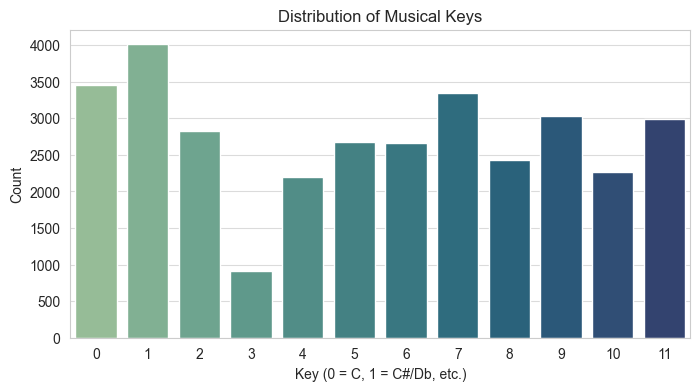

In [26]:
plt.figure(figsize=(8, 4))
sns.countplot(x='key', data=df, palette='crest', order=sorted(df['key'].unique()))
plt.title('Distribution of Musical Keys')
plt.xlabel('Key (0 = C, 1 = C#/Db, etc.)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.7)
plt.show()

Тональность довольно ровно распределена относительно всех видов, однако в количество треков в 3 типе значительно меньше, трудно объяснить причину данного спада

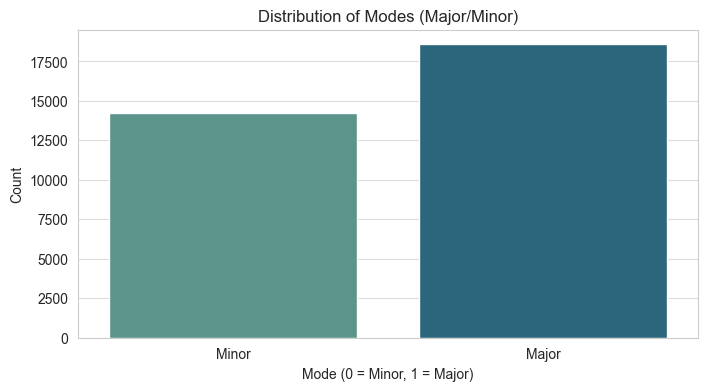

In [27]:
plt.figure(figsize=(8, 4))
sns.countplot(x='mode', data=df, palette='crest')
plt.title('Distribution of Modes (Major/Minor)')
plt.xlabel('Mode (0 = Minor, 1 = Major)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Minor', 'Major'])
plt.grid(axis='y', alpha=0.7)
plt.show()

Большая часть треков сделана в мажоре, что значит преобладание веселых и бодрых треков

1. Энергичность и громкость: Современная музыка становится всё более энергичной, что выражается в увеличении значения показателей energy и loudness. Особенно это заметно с конца 1990-х годов.
Музыка с высокой энергичностью ассоциируется с быстрыми и яркими жанрами, такими как pop, rap и EDM.

2. Танцевальность: В последние десятилетия танцевальные треки приобрели большую популярность. Жанры rap и latin лидируют по танцевальности (danceability), что объясняет их высокую востребованность на вечеринках и мероприятиях.

3. Сокращение продолжительности треков: Анализ показал, что современные треки в среднем короче, чем в предыдущие десятилетия. Это может быть связано с трендом на быстрое потребление контента и популярностью стриминговых платформ.

4. Популярные жанры: Жанр pop остаётся самым популярным, демонстрируя наивысшие значения популярности (track_popularity). За ним следуют такие жанры, как rap и dance, которые часто используют высокую танцевальность и энергичность для привлечения слушателей.

5. Позитивное настроение треков: Музыка с высокой валентностью (valence), выражающая позитивные эмоции, такие как радость и веселье, остаётся наиболее востребованной. Большая часть популярных треков написана в мажоре (mode), что подчёркивает предпочтение слушателей к бодрым и весёлым композициям.

6. Эволюция музыкальных характеристик:

    - До 1970-х годов наблюдаются хаотичные данные, что объясняется ограниченностью информации.
    - С конца 20-го века усилилась роль лирики и танцевальности в треках.
    - Сложные треки с высоким уровнем акустичности постепенно теряют популярность, уступая место более динамичным и электронным композициям.

7. Особенности поджанров:
    - Поджанры, такие как electropop и trap, показывают ярко выраженную популярность среди молодежи, благодаря своим танцевальным ритмам и энергичности.
    - Более медленные и продолжительные треки характерны для жанров, таких как rock и classical, которые сохраняют аудиторию с классическими вкусами.

# Система Рекомендаций

Было подготовлено 3 системы рекомендации от самой простой к самой сложной. Затем приведен пример работы на основе трека Басты "Выпускной"

## Подготовка данных

Создадим функцию для преобразования данных к одному масштабу и преобразовании нужных категориальных фич в числовой формат

In [28]:
def preprocess_data(data):
    feature_columns = data.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[feature_columns])

    if 'genre' in data.columns:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        genre_encoded = encoder.fit_transform(data[['genre']])
        processed_features = np.hstack([scaled_features, genre_encoded])
    else:
        processed_features = scaled_features

    return processed_features

In [29]:
processed_features = preprocess_data(df)

## "Наивная" рекомендация на основе косинусной похожести

Для начала стоит объяснить работу данного алгоритма, и почему я называю данный подход "наивным"

Рекомендации на основе косинусной похожести — это метод, основанный на вычислении угла между векторами, представляющими объекты в многомерном пространстве признаков. Чем меньше угол, тем больше схожесть.

Особенности:
1. Одномерный подход: Косинусная схожесть измеряет только угол между векторами, игнорируя их длину. Это упрощает анализ, но может упустить важные аспекты, например, разницу в важности признаков или масштабах данных.

2. Невключение контекста: Такой подход не учитывает динамические аспекты

3. Отсутствие персонализации: Косинусная схожесть больше подходит для измерения сходства между объектами (например, фильмами или товарами), но она не учитывает уникальные предпочтения конкретного пользователя. Однако данную проблему невозможно решить в контексте выбранного датасета, так как нет данных пользователей и не с кого строить u2

4. Линейность: Косинусная схожесть не способна улавливать нелинейные зависимости между объектами, что делает её недостаточно эффективной в сложных сценариях.

In [30]:
def recommend_songs(song_name, data, processed_features, n_recommendations=5):
    if song_name not in data['track_name'].values:
        return f"Песня '{song_name}' не найдена. Проверьте правильность названия."

    song_index = data[data['track_name'] == song_name].index[0]
    song_features = processed_features[song_index].reshape(1, -1)

    similarity_scores = cosine_similarity(song_features, processed_features).flatten()

    data['similarity'] = similarity_scores
    
    recommendations = data[data['track_name'] != song_name].sort_values(by='similarity', ascending=False)
    recommendations = recommendations.drop_duplicates(subset=['track_name', 'track_artist'])
    return recommendations[['track_name', 'track_artist', 'similarity']].head(n_recommendations)

Пример работы

In [31]:
song_to_recommend = "Выпускной (Медлячок)"
recommended_songs = recommend_songs(song_to_recommend, df, processed_features)

if isinstance(recommended_songs, str):
    print(recommended_songs)
else:
    print(f"Песни, похожие на: {song_to_recommend}, автора: {df[df.track_name == song_to_recommend]['track_artist'].head(1).item()}")
    print(recommended_songs)

Песни, похожие на: Выпускной (Медлячок), автора: Basta
               track_name  track_artist  similarity
7870   Gangsta's Paradise        Coolio    1.000000
22379     If I Were a Boy       Beyoncé    0.860757
25083       Bump n' Grind      R. Kelly    0.837990
12356             Cocaine  Eric Clapton    0.832467
21837    How Do I Breathe         Mario    0.825705


## Кластеризация и выбор ближайщих соседей в кластере

Основная идея подхода — уменьшить размерность исходной выборки, то есть группировать песни по схожим характеристикам (кластеризация), а затем искать наиболее близкие композиции к выбранной песне в пределах её кластера.

Основные характеристики системы:
1. Кластеризация песен:
    Используется алгоритм K-Means для разделения всех песен на кластеры на основе их обработанных признаков (например, аудио характеристик: темпа, тональности, энергии и т. д.).
Каждая песня принадлежит одному из заранее определённых кластеров.
2. Рекомендации в пределах кластера: После выбора песни система определяет её кластер. С помощью алгоритма Nearest Neighbors находятся песни из того же кластера, которые наиболее близки к выбранной композиции по характеристикам.
3. Визуализация кластеров: Для наглядности используется метод снижения размерности (PCA) для отображения кластеров в двухмерном пространстве. Каждому кластеру присваивается свой цвет для удобства анализа и интерпретации.

Преимущества системы:
- Эффективность: Кластеризация позволяет сузить выбор похожих песен, что ускоряет процесс рекомендаций.
- Наглядность: Визуализация кластеров даёт пользователям и разработчикам интуитивное понимание структуры музыкального пространства.
- Гибкость: Система поддерживает настройку количества кластеров и рекомендуемых песен.

Недостатки системы:
- Ограниченность кластеров: Требуется заранее задавать число кластеров, что может привести к слишком общим или слишком узким группам.
- Игнорирование пользовательских предпочтений: Рекомендации строятся только на характеристиках песен, без учёта истории прослушиваний и поведения пользователя. Данную проблему так же нельзя решить в контексте данного проекта из за ограниченности датасета.
- Границы кластеров: Песни на границе между кластерами могут быть отнесены неверно, что снижает точность рекомендаций.
- Сферическая форма: Кластеры KNN предполагают сферическую форму, что далеко не всегда лучшим образом описывает разделение.

In [32]:
def recommend_songs_with_clustering(song_name, data, processed_features, n_recommendations=5, n_clusters=10):
    if song_name not in data['track_name'].values:
        return f"Песня '{song_name}' не найдена в данных. Проверьте правильность названия."

    data = data.reset_index(drop=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['cluster'] = kmeans.fit_predict(processed_features)

    song_cluster = data[data['track_name'] == song_name]['cluster'].iloc[0]

    cluster_songs = data[data['cluster'] == song_cluster]
    cluster_indices = cluster_songs.index

    cluster_features = processed_features[cluster_indices]

    nbrs = NearestNeighbors(n_neighbors=min(n_recommendations + 1, len(cluster_indices))).fit(cluster_features)
    song_index = data[data['track_name'] == song_name].index[0]
    song_features = processed_features[song_index].reshape(1, -1)

    distances, indices = nbrs.kneighbors(song_features)

    recommendations_indices = cluster_indices[indices[0][1:]]
    recommendations = data.loc[recommendations_indices]

    return recommendations[['track_name', 'track_artist', 'cluster']]




def plot_clusters(data, processed_features, n_clusters=10):
    data = data.reset_index(drop=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(processed_features)

    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(processed_features)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title('Визуализация кластеров с помощью PCA')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.show()


Пример работы

In [33]:
song_to_recommend = "Выпускной (Медлячок)"
recommended_songs_cluster = recommend_songs_with_clustering(song_to_recommend, df, processed_features)

if isinstance(recommended_songs_cluster, str):
    print(recommended_songs_cluster)
else:
    print(f"Песни, похожие на: {song_to_recommend}, автора: {df[df.track_name == song_to_recommend]['track_artist'].head(1).item()}")
    print(recommended_songs_cluster)


Песни, похожие на: Выпускной (Медлячок), автора: Basta
                       track_name      track_artist  cluster
12857             Smell the Roses      Roger Waters        3
28525                  Gold Skies  Sander van Doorn        3
8494                   Lady Karma        Sonny Bama        3
10113                  La Ocasión          DJ Luian        3
31099  Wasted - Ummet Ozcan Remix            Tiësto        3


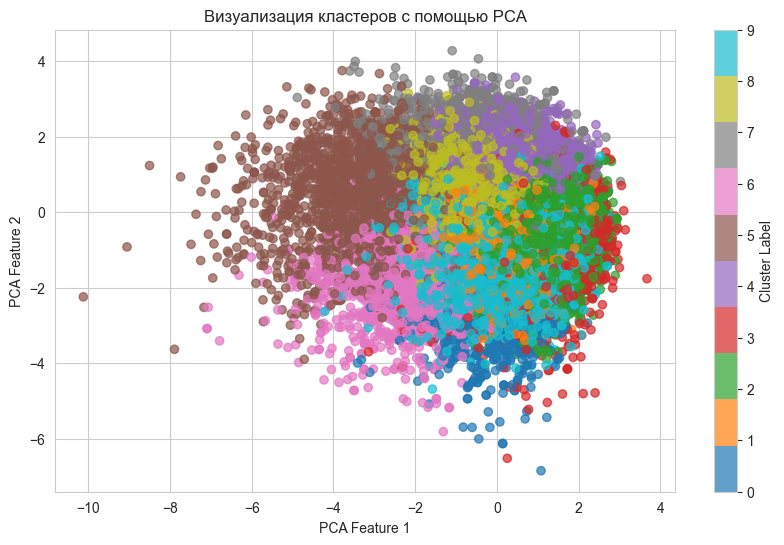

In [34]:
plot_clusters(df, processed_features)


Если посмотреть на распределение по кластерам, то визуально оно неплохое, кластеры выделяются довольно четко, за исключением перечесения некоторых отдельных групп.

## Автоэнкодер

Основная идея подхода - создание системы рекомендаций, основанной на использовании автоэнкодера для снижения размерности данных и дальнейшего поиска наиболее похожих треков с помощью вычисления косинусного сходства между их зашифрованными представлениями. Это позволяет находить треки, которые звучат похоже, на основе их аудиохарактеристик.

Основные характеристики системы:
1. Модель автоэнкодера: Для снижения размерности данных применяется нейронная сеть автоэнкодер. Она состоит из двух частей:
    - Энкодер: Сжимает исходные данные в более компактное представление (вектор меньшей размерности).
    - Декодер: Восстанавливает данные из зашифрованного представления. 
    
    В процессе обучения автоэнкодер минимизирует ошибку восстановления, что помогает улучшить качество представления данных.

2. Рекомендации на основе сходства

Преимущества системы:
- Гибкость и масштабируемость: Подход подходит для работы с большими наборами данных и позволяет эффективно обрабатывать разнообразные музыкальные характеристики.
- Автоматическое извлечение признаков: Автоэнкодер сам находит скрытые представления данных, что уменьшает зависимость от ручного выбора признаков.
- Скорость работы: Для каждого трека быстро находят похожие композиции благодаря вычислению косинусного сходства в пространстве с пониженными размерами.

Качественное отличие от косинусной похожести:

- Косинусная похожесть в своем базовом варианте обычно работает с оригинальными признаками (например, с аудиохарактеристиками вроде темпа, громкости, акустичности и других). Однако эти признаки могут быть шумными или избыточными. Простое вычисление косинусной похожести может не всегда учитывать сложные зависимости между признаками.
- Автоэнкодер, с другой стороны, обучается извлекать наиболее важные и скрытые признаки данных, сокращая их размерность до компактного представления. Это представление (или код) является более информативным и отражает глубокие, скрытые структуры данных, которые могут быть трудны для прямого захвата с помощью традиционных методов.

    Допустим, у нас есть два трека с одинаковым темпом, но один — с яркой акустической составляющей, а другой — с электронной музыкой. Классическая косинусная похожесть может посчитать их разными, потому что некоторые аудиохарактеристики могут сильно отличаться. Однако автоэнкодер, скорее всего, учтет их схожесть по более высокоуровневым признакам, таким как эмоциональное восприятие или жанровая принадлежность, что сделает рекомендацию более точной


Автокодировщик (англ. autoencoder) — специальная архитектура искусственных нейронных сетей, позволяющая применять обучение без учителя при использовании метода с обратного распространения ошибки. Простейшая архитектура автокодировщика — сеть прямого распространения, без обратных связей, наиболее схожая с перцептроном и содержащая входной слой, промежуточный слой и выходной слой. В отличие от перцептрона , выходной слой автокодировщика должен содержать столько же нейронов, сколько и входной слой.

Автокодировщик состоит из двух частей: энкодера g
и декодера f. Энкодер переводит входной сигнал в его представление (код): h=g(x), а декодер восстанавливает сигнал по его коду: x=f(h).

Автокодировщик, изменяя f и g, стремится выучить тождественную функцию x=f(g(x)), минимизируя какой-то функционал ошибки. L(x,f(g(x)))

<p style="text-align: center;">
  <img src="src/image.png" alt="image" />
</p>
Источник: https://neerc.ifmo.ru/wiki/index.php?title=%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA

In [42]:
features = ['tempo', 'loudness', 'acousticness', 'valence', 'duration_ms', 'speechiness']
X = df[features].values
encoder = OneHotEncoder(handle_unknown='ignore')
mode_encoded = encoder.fit_transform(df[['mode']])
X = np.hstack([X, mode_encoded.toarray()])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, encoding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


input_dim = X_tensor.shape[1]
encoding_dim = 64

model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model.train()
    
    output = model(X_tensor)
    
    loss = criterion(output, X_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
encoded_X = model.encoder(X_tensor).detach().numpy()

similarity_matrix = cosine_similarity(encoded_X)

Epoch [10/50], Loss: 0.6431
Epoch [20/50], Loss: 0.5890
Epoch [30/50], Loss: 0.5710
Epoch [40/50], Loss: 0.5630
Epoch [50/50], Loss: 0.5587


In [47]:
def recommend_tracks_autoencoder(track_index, similarity_matrix, df, top_n=5):
    similar_tracks = similarity_matrix[track_index].argsort()[::-1][1:]
    recommended_set = set()
    recommendations = []
    
    for idx in similar_tracks:
        if idx == track_index or df.iloc[idx]['track_name'] in recommended_set:
            continue
        
        recommended_set.add(df.iloc[idx]['track_name'])
        
        recommendations.append({
            'track_name': df.iloc[idx]['track_name'],
            'track_artist': df.iloc[idx]['track_artist'],
            'track_popularity': df.iloc[idx]['track_popularity'],
            'track_album_name': df.iloc[idx]['track_album_name'],
        })
        if len(recommendations) == top_n:
            break
    
    return recommendations

Пример работы

In [49]:
song_to_recommend = "Выпускной (Медлячок)"
song_index = df[df['track_name'] == song_to_recommend].index[0]
recommended_tracks = recommend_tracks_autoencoder(song_index, similarity_matrix, df)

print(f"Песни, похожие на: {song_to_recommend}, автора: {df[df.track_name == song_to_recommend]['track_artist'].head(1).item()}")
for track in recommended_tracks:
    print(f"{track['track_name']} - {track['track_artist']} - {track['track_popularity']}")

Песни, похожие на: Выпускной (Медлячок), автора: Basta
Gangsta's Paradise - Coolio - 80
Troubled World (feat. Kelly Price & Jessica Reedy) - Faith Evans - 7
Summertime - DJ Jazzy Jeff & The Fresh Prince - 44
I'd Love You to Want Me - Lobo - 51
Mean It - Lauv - 85


## Сравнение результатов

Трек взятый за пример - Баста "Выпускной"
|           | Cos Similarity | Clusterisation | Autoencoder |
|-----------|----------------|----------------|-------------|
| 1         | Gangsta's Paradise      | Smell the Roses       | Gangsta's Paradise    |
| 2         | If I Were a Boy       | Gold Skies       | Troubled World (feat. Kelly Price & Jessica Reedy)   |
| 3         | Bump n' Grind       | Lady Karma      | Summertime    |
| 4         | Cocaine       | La Ocasión       | I'd Love You to Want Me    |
| 5         | How Do I Breathe       | Wasted - Ummet Ozcan Remix       | Mean It    |

Можно заметить, что и в первом подходе, и в последнем, самым похожим на Баста - "Выпускной" является трек Gangsta's Paradise. Это может говорить о сильной линейной зависимости между данными треками, а так же о некоторой схожести двух алгоритмов ввиду использования косинусной похожести в обоих. Однако во 2 алгоритме такого трека вприницпе нет, что показывает сильное отличие в принципе отбора подходящих треков от двух других.

Прослушав большинство треков из представленных, по моей субъективной оценке, в них дейстивтельно есть некоторое сходство с исследумой песней, а наболее подходящаяя подборка в 3 варианте, что показывает, пусть и субъективно, что напсианные алгоритмы для рекомендаций работают

# Результат проекта

В рамках проекта был проведён анализ и визуализация датасета 30000 музыкальных треков с платформы Spotify с целью создания системы рекомендаций. 

Проект включал несколько этапов:

1. Анализ данных:
    
    Данный этап включал в себя загрузку, первичную обработку и анализ всего массива данных по различным фичам и их совокупностям, а затем выделение ключевых тенденций в современной музке

2. Построение системы рекомендаций

    Было написано 3 вида рекомендаций:
        
    - На основе обычной косинусной похожести
    - На основе кластеризации
    - На основе dl, в частности такой архитектуры, как Autoencoder

    Проведено сравнение результатов данных алгоритмов на примере одной песни из датасета

Направления для улучшения:

1. Для построения более серьезной, персоналезированной системы рекомендаций крайне не хватило данных пользователей
2. Увеличение в целом количества произведений в исходных данных
3. Использование гибридных подходов постороения систем рекомендаций, включающих в себя сразу несколько алгоритмов сразу 
